# Elementary research

This notebook examines several basic assembly operations.

In [66]:
%load_ext autoreload
%autoreload 2

import itertools
import random
import lascar
import matplotlib.pyplot as plt
import numpy as np

import datasets
from leakage_detection_loop import cpa_full, njit

lascar.logger.setLevel(lascar.logging.CRITICAL)
plt.rcParams['figure.figsize'] = [15.0, 4.0]
plt.rcParams['figure.dpi'] = 140

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../capture/elmo")
import elmo_capture_generic
elmo_capture_generic.STDERR_TO_NULL = True


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def randbytes(n):
    return [random.randint(0, 255) for _ in range(n)]

In [44]:
def asmcapture(number_of_traces, inputfunction, asmcode):
    asmcode = '\n'.join([f'"{line} \\n"' for line in asmcode.splitlines()])
    return elmo_capture_generic.capture(
        name="elmo",
        number_of_traces=number_of_traces,
        inputfunction=inputfunction,
        save=False,
        code=f'asm(\n{asmcode}\n:: "r"(input));'
    )

## Behavior of different bytes in one operation

In [55]:
data = asmcapture(
    number_of_traces=10_000,
    inputfunction=lambda: randbytes(8),
    asmcode="""
        ldr r0, [%0]
        nop\nnop\nnop\nnop
        str r0, [%0, #4]
        """
)

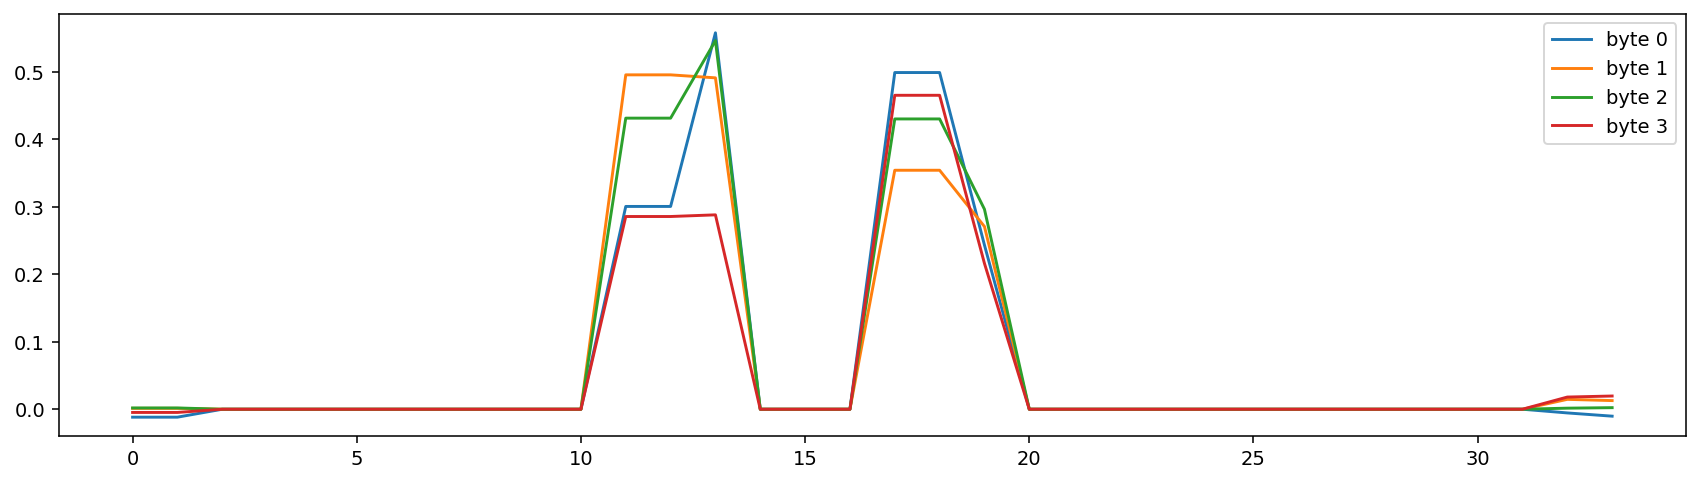

In [56]:
for i in range(4):
    cpa = cpa_full(
        dataset=data,
        selection_function=lambda value, _: lascar.hamming(value["input"][i]),
        guess_range=range(1),
    )
    plt.plot(cpa, label=f"byte {i}")

plt.legend()
plt.show()


# Second Order

In [61]:
def cpa_full_secondorder(dataset, selection_function, guess_range, rois):
    class CpaOutput(lascar.OutputMethod):
        def _update(self, engine, results):
            self.result = results[0]

    trace = lascar.TraceBatchContainer(dataset["trace"], dataset)
    trace.leakage_processing = lascar.CenteredProductProcessing(
        container=trace,
        rois=rois,
        batch_size=100_000
    )

    engine = lascar.CpaEngine(
        name=f"cpa",
        selection_function=selection_function,
        guess_range=guess_range,
    )
    output_method = CpaOutput(engine)
    session = lascar.Session(
        trace,
        engine=engine,
        output_method=output_method,
        progressbar=False,
    )
    session.run(batch_size=100_000)
    return output_method.result

In [71]:
data = asmcapture(
    number_of_traces=10_000,
    inputfunction=lambda: randbytes(3),
    asmcode="""
        ldrb r0, [%0]
        ldrb r0, [%0, #2]
        nop\nnop\nnop\nnop
        ldrb r1, [%0, #1]
        """
)


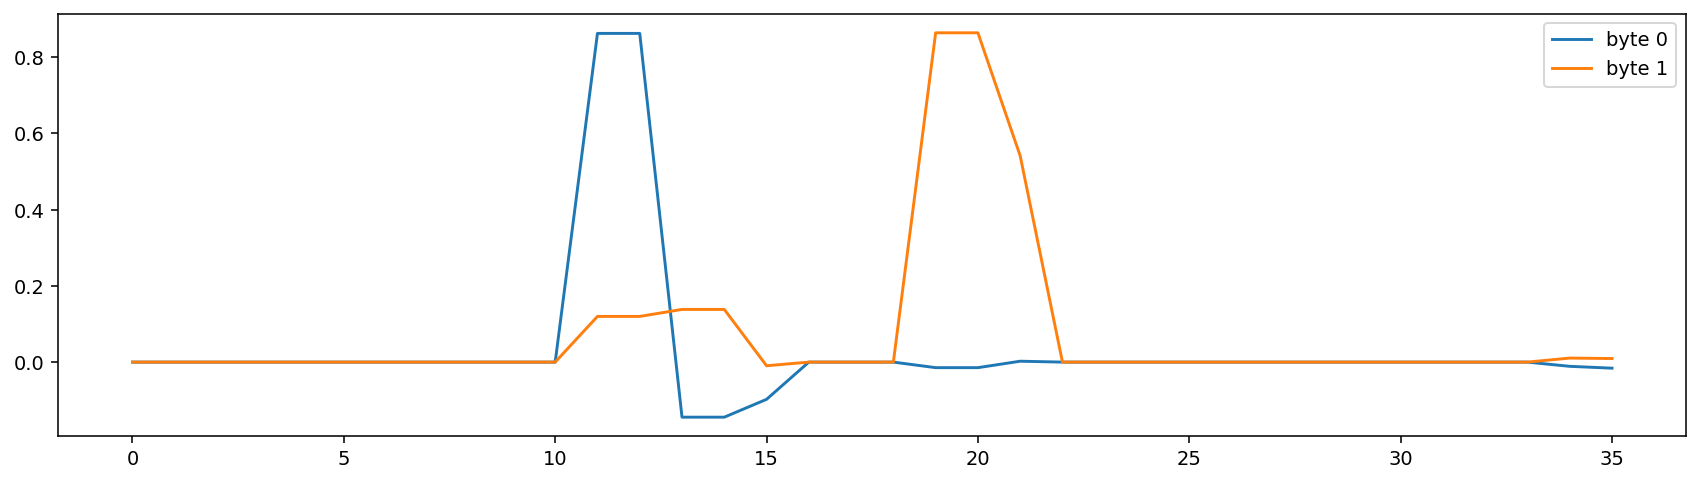

In [60]:
for i in range(2):
    cpa = cpa_full(
        dataset=data,
        selection_function=lambda value, _: lascar.hamming(value["input"][i]),
        guess_range=range(1),
    )
    plt.plot(cpa, label=f"byte {i}")

plt.legend()
plt.show()



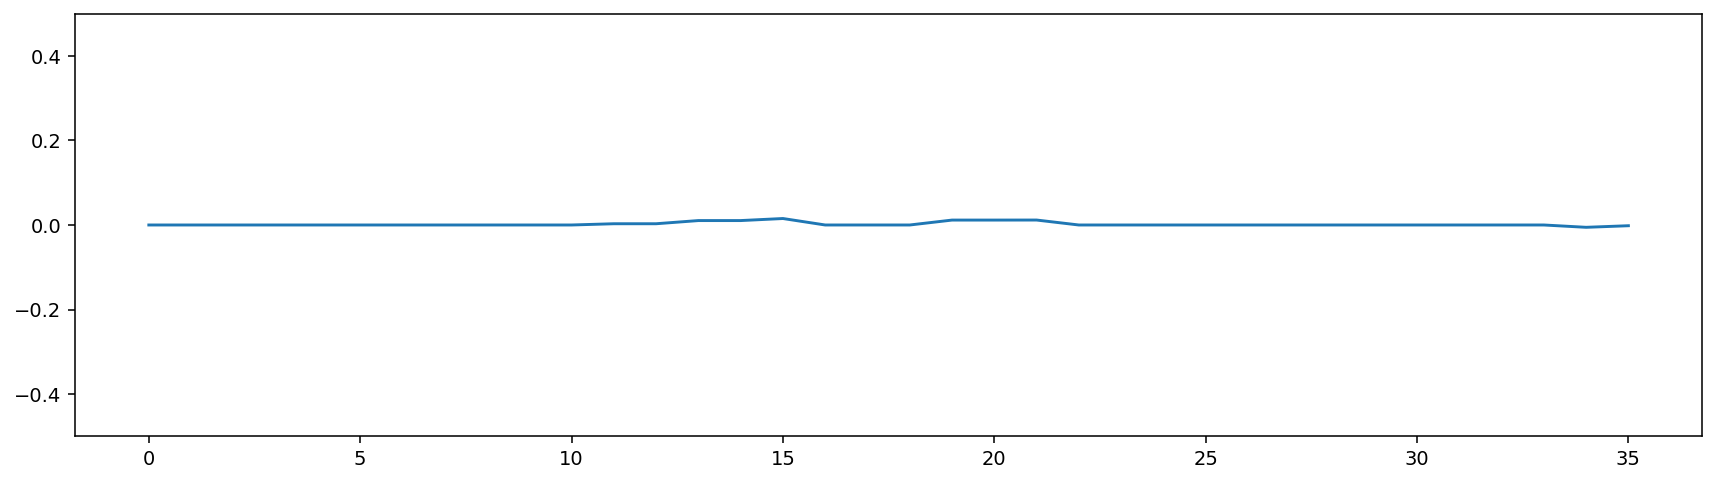

In [63]:
cpa = cpa_full(
    dataset=data,
    selection_function=lambda value, _: lascar.hamming(value["input"][0] ^ value["input"][1]),
    guess_range=range(1),
)
plt.ylim((-0.5, 0.5))
plt.plot(cpa)
plt.show()


CenteredProduct: |  0%||0 trc/10000 | (2 engines, batch_size=100000, leakage_shape=(36,)) |ETA:  --:--:--
CenteredProduct: |100%||10000 trc/10000 | (2 engines, batch_size=100000, leakage_shape=(36,)) |Time:  0:00:00


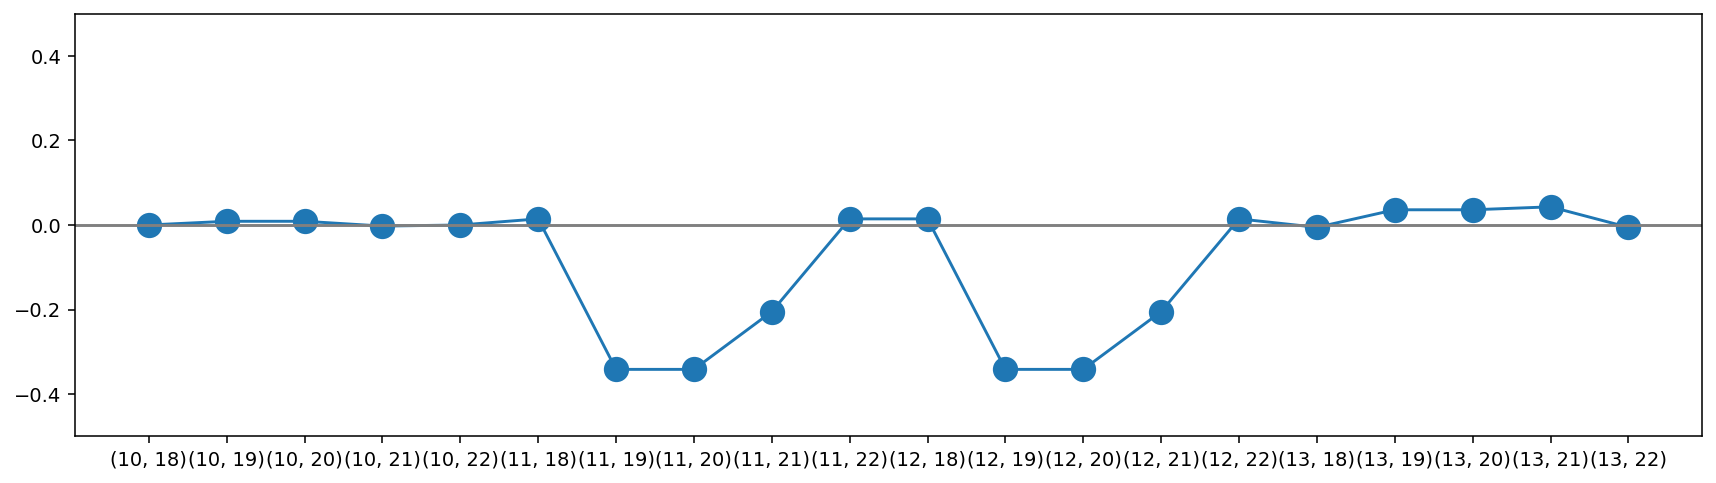

In [72]:
rois = (range(10, 14), range(18, 23))
cpa = cpa_full_secondorder(
    dataset=data,
    selection_function=lambda value, _: lascar.hamming(value["input"][0] ^ value["input"][1]),
    guess_range=range(1),
    rois=rois
)
plt.plot([str(i) for i in itertools.product(*rois)], cpa, marker="o", markersize=12)
plt.xticks(np.arange(plt.xlim()[1]))
plt.axhline(0, color="gray")
plt.ylim((-0.5, 0.5))
plt.show()